In [33]:
%pip install pandas scikit-learn numpy matplotlib xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 2.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd

df = pd.read_csv("train_FD001.txt", sep=" ", header=None)
df.dropna(axis=1, inplace=True)  # Remove empty columns

In [10]:
columns = ['unit', 'cycle'] + [f'op_setting_{i}' for i in range(1, 4)] + [f'sensor_{i}' for i in range(1, 22)]
df.columns = columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   unit          20631 non-null  int64  
 1   cycle         20631 non-null  int64  
 2   op_setting_1  20631 non-null  float64
 3   op_setting_2  20631 non-null  float64
 4   op_setting_3  20631 non-null  float64
 5   sensor_1      20631 non-null  float64
 6   sensor_2      20631 non-null  float64
 7   sensor_3      20631 non-null  float64
 8   sensor_4      20631 non-null  float64
 9   sensor_5      20631 non-null  float64
 10  sensor_6      20631 non-null  float64
 11  sensor_7      20631 non-null  float64
 12  sensor_8      20631 non-null  float64
 13  sensor_9      20631 non-null  float64
 14  sensor_10     20631 non-null  float64
 15  sensor_11     20631 non-null  float64
 16  sensor_12     20631 non-null  float64
 17  sensor_13     20631 non-null  float64
 18  sensor_14     20631 non-nu

In [11]:
# Remove sensor columns with no variance (manual based on NASA docs)
drop_sensors = ['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
df.drop(columns=drop_sensors, inplace=True)

In [13]:
from sklearn.preprocessing import MinMaxScaler

columns_to_normalize = [col for col in df if col not in ['unit', 'cycle']]
scaler = MinMaxScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

In [14]:
rul_df = df.groupby('unit')['cycle'].max().reset_index()
rul_df.columns = ['unit', 'max_cycle']

In [15]:
df = df.merge(rul_df, on='unit')
df['RUL'] = df['max_cycle'] - df['cycle']
df.drop(columns=['max_cycle'], inplace=True)

In [17]:
df.sample(5)

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL
13587,68,156,0.339080,0.583333,0.0,0.692771,0.576630,0.606685,0.420290,0.287879,0.295656,0.607143,0.379531,0.294118,0.324543,0.469411,0.416667,0.356589,0.507457,43
4103,20,170,0.568966,0.833333,0.0,0.292169,0.481578,0.592167,0.426731,0.378788,0.184286,0.470238,0.445629,0.352941,0.214780,0.580608,0.416667,0.356589,0.496410,64
438,2,247,0.425287,0.333333,0.0,0.503012,0.657510,0.528528,0.420290,0.303030,0.238939,0.505952,0.409382,0.382353,0.255754,0.575606,0.500000,0.341085,0.453880,40
5215,26,106,0.545977,0.750000,0.0,0.620482,0.399172,0.413234,0.502415,0.257576,0.145158,0.476190,0.562900,0.411765,0.190164,0.453251,0.333333,0.503876,0.482049,93
7378,38,63,0.247126,0.416667,0.0,0.370482,0.321779,0.461681,0.513688,0.287879,0.100691,0.458333,0.705757,0.338235,0.148571,0.445556,0.416667,0.565891,0.532312,131


In [19]:
feature_cols = [col for col in df.columns if col not in ["unit", "cycle", "RUL"]]
X = df[feature_cols]
y = df['RUL']

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape


((16504, 17), (16504,))

In [21]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 34.07
MSE: 1967.18
RMSE: 44.35


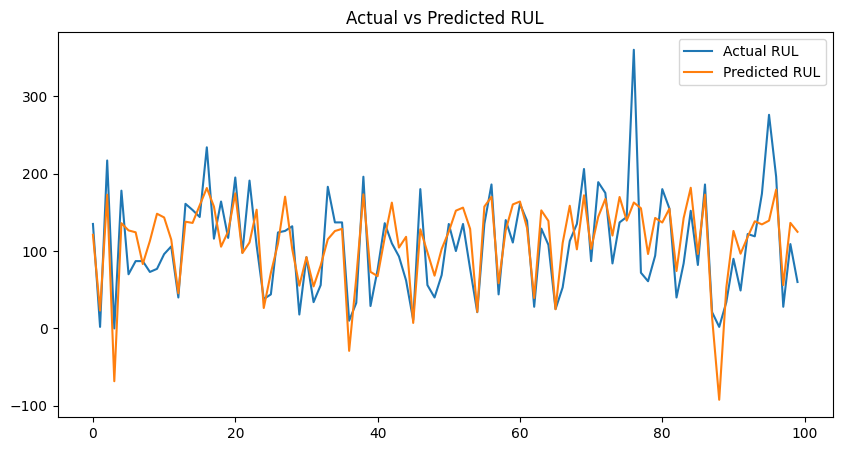

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:100], label='Actual RUL')
plt.plot(y_pred[:100], label='Predicted RUL')
plt.title("Actual vs Predicted RUL")
plt.legend()
plt.show()

In [31]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, max_depth = 10, random_state=42)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)

In [32]:
rf_mae = mean_absolute_error(y_test, y_pred)
rf_mse = mean_squared_error(y_test, y_pred)
rf_rmse = np.sqrt(rf_mse)

print(f"Random Forest MAE: {rf_mae}")
print(f"Random Forest MSE: {rf_mse}")
print(f"Random Forest RMSE: {rf_rmse}")

Random Forest MAE: 34.06533283885381
Random Forest MSE: 1967.178629510056
Random Forest RMSE: 44.352887499125195


In [37]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42)
xgb_model = xgb.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)

In [35]:
xgb_mae = mean_absolute_error(y_test, y_pred)
xgb_mse = mean_squared_error(y_test, y_pred)
xgb_rmse = np.sqrt(xgb_mse)

print(f"XGBoost MAE: {xgb_mae}")
print(f"XGBoost MSE: {xgb_mse}")
print(f"XGBoost RMSE: {xgb_rmse}")

XGBoost MAE: 30.052444458007812
XGBoost MSE: 1786.7822265625
XGBoost RMSE: 42.27034689427684


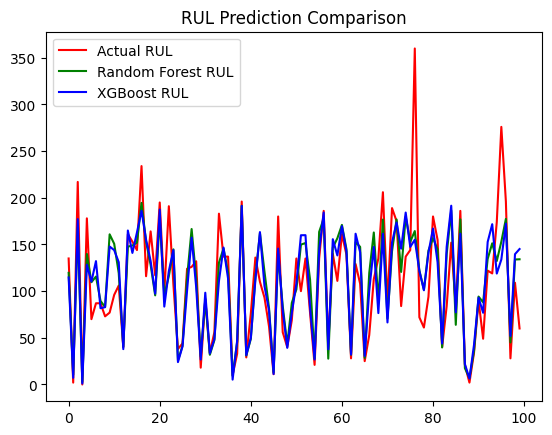

In [39]:
plt.plot(y_test.values[:100], 'r', label='Actual RUL')
plt.plot(rf_pred[:100], 'g', label='Random Forest RUL')
plt.plot(xgb_pred[:100], 'b', label='XGBoost RUL')
plt.title('RUL Prediction Comparison')
plt.legend()
plt.show()
